In [190]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [219]:
def preprocess_text(text, stop_words):
    """очистка текстовых данных от ссылок, символов и стоп слов
    :param text: Текст
    :param stop_words: Стоп слова
    :return processed_text: Очищенный текст"""
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^A-Za-zА-Яа-я\s]', '', text)
    text = text.lower()
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    processed_text = ' '.join(filtered_words)
    return processed_text

Загружаем и предобрабатываем набор данных

In [220]:
data_path = Path('dataset/rusentiment_preselected_posts.csv')

In [221]:
nltk.download('stopwords', download_dir='./stopwords/')
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to ./stopwords/...
[nltk_data]   Package stopwords is already up-to-date!


In [224]:
train_df = pd.read_csv(data_path)
train_df = train_df[train_df['label'].isin(['negative', 'positive', 'neutral'])]
train_df['text'] = train_df['text'].apply(lambda x: preprocess_text(x, stop_words))
train_df

,label,text
0,neutral,прорвм информационную блокаду изнутри
1,negative,одного приложения топку ущербные универсальности
3,neutral,типа людей умные которые делают сразу умные которые откладывают доделывают ясначала впадлу поздно
4,neutral,мегафон чет накрыло
7,neutral,шах мат
...,...,...
6945,positive,знаем лучшиес
6946,neutral,такая ежовая тема
6947,neutral,оно
6948,positive,бляяя это номер такого ожидала ахаха надеюсь никто пострадал ребят никому звонила


In [225]:
train_df['label'].value_counts()

label
neutral     2977
positive    1475
negative    1360
Name: count, dtype: int64

Сразу стоит обратить внимание на дисбаланс классов (экземпляров neutral в исходных данных представлено практически в два раза больше чем positive или negative). Учтем это в дальнейшем при интерпретации результатов обучения моделей.

Векторизуем данные с 5000 признаками. Такой выбор max_features обусловлен большим количеством исходных данных.

In [226]:
tfidf = TfidfVectorizer(max_features=5000)

In [227]:
X = tfidf.fit_transform(train_df['text'])

Визуализация данных

In [228]:
tsne = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2)

X_tsne = tsne.fit_transform(X.toarray())
X_pca = pca.fit_transform(X.toarray())

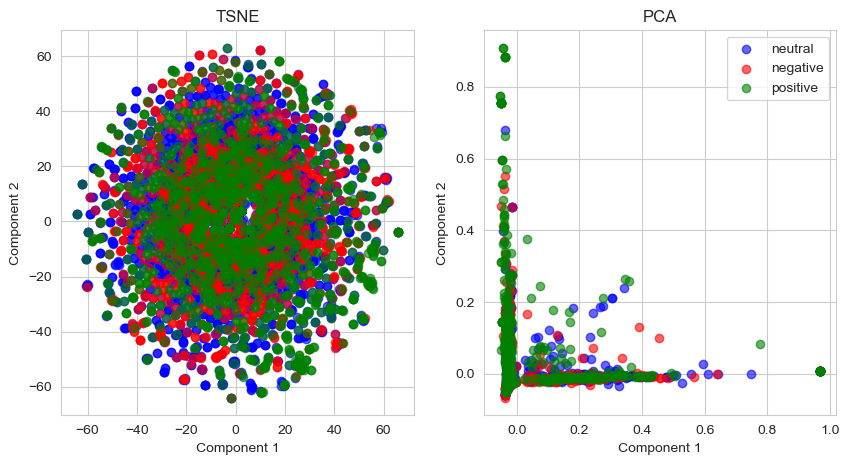

In [229]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}

# Визуализируем данные
for label in train_df['label'].unique():
    for i, X in enumerate([('TSNE', X_tsne),('PCA', X_pca)]):
        # Выбираем индексы строк, где label соответствует текущему классу
        mask = train_df['label'] == label
        ax[i].scatter(X[1][mask, 0], X[1][mask, 1], 
                color=colors[label], label=label, alpha=0.6)
        ax[i].set_title(X[0])
        ax[i].set_xlabel("Component 1")
        ax[i].set_ylabel("Component 2")   
plt.legend()
plt.show()

Используя методы PCA и t-SNE для снижения размерности исходных данных TF-IDF с 5000 признаков до двух (для визуализации на 2D графике), можно заметить, что данные имеют достаточно нелинейную структуру, учтем это при интерпретации результатов обучения моделей.

Перейдем непосредственно к обучению моделей, разделим выборку на train и test

In [230]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'], train_df['label'], test_size=0.2, random_state=0)

X_train_v = tfidf.fit_transform(X_train)
X_test_v = tfidf.transform(X_test)

Инициализируем и обучаем модели

In [231]:
def validate_with_metrics(model, x_train, y_train, x_test, y_test):
    """
    Выполняет обучение моделей и сохранение метрик
    :param model: обучаемая модель
    :param x_train: обучающая выборка
    :param y_train: обучающие метки классов
    :param x_test: тестовая выборка
    :param y_test: тестовые метки классов
    :return model, result: Обученная модель и словарь с истинными, предсказанными значениями, а также метриками
    """
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    acc = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')
    
    result = {'Predictions': pred,
               'True Labels': y_test,
               'Accuracy': acc,
               'Precision': precision,
               'Recall': recall,
               'F1-score': f1}
    return model, result

Инициализируем модели и проводим их обучение.

Модели были выбраны исходя из следующих соображений:

*Naive Bayes* - предположительно может показать себя неплохо ввиду возможности эффективной работы с разряженными и высокомерными данными (как раз дял нашего представления через TF-IDF). 

*Logistic Regression* - навряд ли подойдет для данной задачи, поскольку эффективна на линейно разделимых данных, тем не менее полезна благодаря своей интерпретируемости и возможности вероятностной оценки наиболее значимых для классификации признаков.

 *Decision Tree* - может работать с нелинейными зависимостями, что полезно в рамках этой задаче, поскольку возможно сможет оценить более сложную семантику текстов (т.е. извлекать признаки из комбинации слов). 

In [232]:
lr_model = LogisticRegression(max_iter=200)
lr_model, lr_results = validate_with_metrics(lr_model, X_train_v, y_train, X_test_v, y_test)

dt_model = DecisionTreeClassifier()
dt_model, dt_results = validate_with_metrics(dt_model, X_train_v, y_train, X_test_v, y_test)

nb_model = MultinomialNB()
nb_model, nb_results = validate_with_metrics(nb_model, X_train_v, y_train, X_test_v, y_test)

Визуализируем метрики после обучения моделей

In [233]:
# Построение графика
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes']
all_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

metric_data = {'Model': [], 'Metric': [], 'Score': []}
for model_name, results in zip(model_names, [lr_results, nb_results, dt_results]):
    for metric in all_metrics:
        score = results[metric].mean()
        metric_data['Model'].append(model_name)
        metric_data['Metric'].append(metric)
        metric_data['Score'].append(score)

metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Metric,Score
0,Logistic Regression,Accuracy,0.582975
1,Logistic Regression,Precision,0.588799
2,Logistic Regression,Recall,0.582975
3,Logistic Regression,F1-score,0.539512
4,Decision Tree,Accuracy,0.579536
5,Decision Tree,Precision,0.646266
6,Decision Tree,Recall,0.579536
7,Decision Tree,F1-score,0.508843
8,Naive Bayes,Accuracy,0.527085
9,Naive Bayes,Precision,0.515809


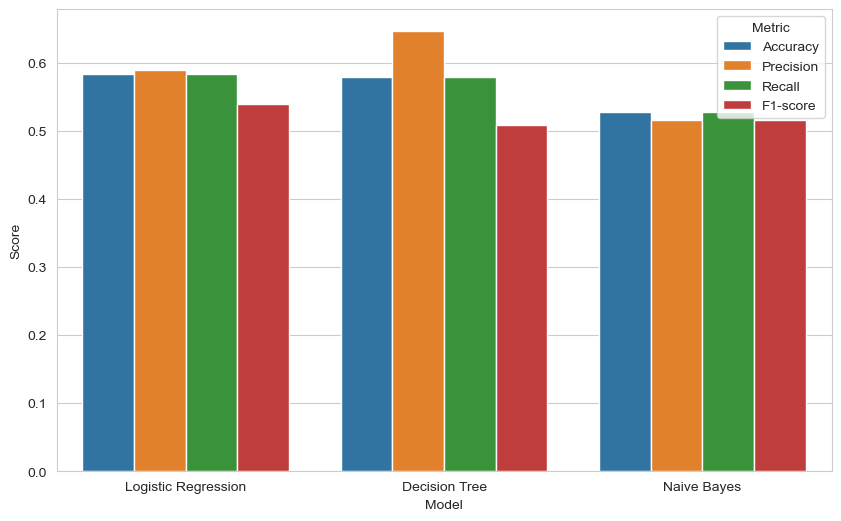

In [234]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metric_df)
plt.legend(title='Metric')
plt.show()

На диаграмме изображены основные метрики: Accuracy, Precision, Recall и F1-score. Это weighted-average метрики по трём классам, поскольку исходные данные плохо сбалансированы. 

Accuracy показывает общее количество верных предсказаний на общем количестве данных, как можно заметить на диаграмме, данная метрика не сильно отличается среди моделей, но заметно ниже у Naive Bayes.

Precision показывает точность предсказаний для каждого класса отдельно, Decision Tree имеет максимальное значение данного показателя.

Recall показывает сколько положительных (TP) примеров для каждого класса модель правильно определяет. У logreg и decision tree примерно одинаковые Recall, у naive bayes поменьше

F1-score является среднегармоническим между precision и recall, (т.е. не учитывает общую точность Accuracy), метрика в целом дает сбалансированное представление о производительности модели в среднем.

Как видно из диаграммы, все модели обладают примерно одинаковым F1-Score, но у logreg чуть больше, 

In [235]:
lr_conf_matrix = confusion_matrix(lr_results['True Labels'], lr_results['Predictions'])
dt_conf_matrix = confusion_matrix(dt_results['True Labels'], dt_results['Predictions'])
nb_conf_matrix = confusion_matrix(nb_results['True Labels'], nb_results['Predictions'])

#для наглядности перейдем от абсолютных значений к процентным
lr_conf_matrix = lr_conf_matrix.astype('float') / lr_conf_matrix.sum(axis=1)[:, np.newaxis] * 100
dt_conf_matrix = dt_conf_matrix.astype('float') / dt_conf_matrix.sum(axis=1)[:, np.newaxis] * 100
nb_conf_matrix = nb_conf_matrix.astype('float') / nb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

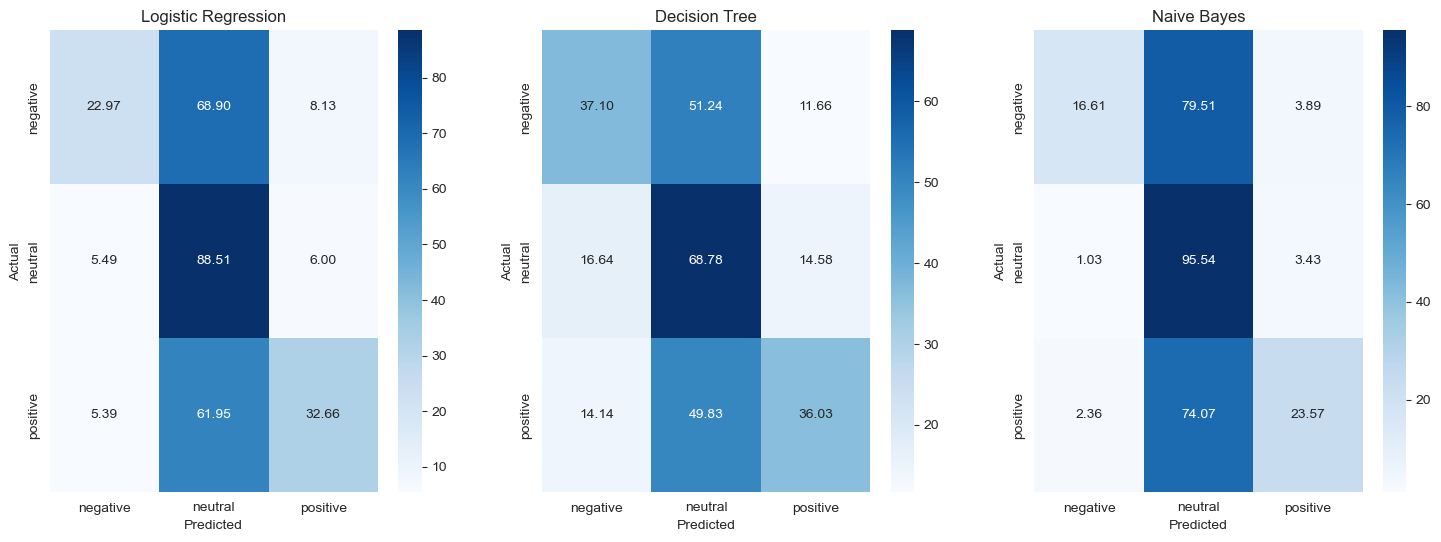

In [236]:
# Создаем subplots для отображения матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, model in enumerate(zip(model_names, [lr_conf_matrix, dt_conf_matrix, nb_conf_matrix])):
    sns.heatmap(model[1], annot=True, fmt='0.2f', cmap='Blues', ax=axes[i], 
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
    axes[i].set_title(model[0])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.show()

Выше отображены матрицы ошибок для двух моделей, значения в элементах матрицы указаны в %

Как можно заметить по матрицам ошибок, модели очень часто относит негативные и позитивные тексты к нейтральным. Основные предположения, которые у меня есть, почему так может происходить: возможно это происходит из-за дизбаланса классов (нейтральных текстов гораздо больше по сравнению с положительными и негативными). Также общие факторы по типу репрезентативности выборки. Для более точной оценки моделей я реализую кросс-валидацию.

In [206]:
def kf_validate(model, x_train, y_train, kf):
    """выполняет обучение и валидацию модели используя k-fold валидацию
    :param model: обучаемая модель
    :param x_train: обучающая выборка
    :param y_train: обучающие метки классов
    :param kf: объект кросс валидатора из sklearn
    :return model, result: Обученная модель и словарь с истинными, предсказанными значениями, а также метриками 
    """
    y_train = y_train.to_numpy()
    accuracies, precisions, recalls, f1s = np.array([]), np.array([]), np.array([]), np.array([])
    all_predictions = np.array([])
    all_true_labels = np.array([])
    
    for train_index, test_index in kf.split(x_train):
        x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
        
        model.fit(x_train_fold, y_train_fold)
        
        y_pred_fold = model.predict(x_test_fold)
        
        all_predictions = np.concatenate([all_predictions, y_pred_fold])
        all_true_labels = np.concatenate([all_true_labels, y_test_fold])
        
        accuracies = np.append(accuracies, accuracy_score(y_test_fold, y_pred_fold))
        precisions = np.append(precisions, precision_score(y_test_fold, y_pred_fold, average='weighted'))
        recalls = np.append(recalls, recall_score(y_test_fold, y_pred_fold, average='weighted'))
        f1s = np.append(f1s, f1_score(y_test_fold, y_pred_fold, average='weighted'))
    
    results = {'Predictions': all_predictions,
               'True Labels': all_true_labels,
               'Accuracy': accuracies,
               'Precision': precisions,
               'Recall': recalls,
               'F1-score': f1s}
    return model, results

In [207]:
X = tfidf.transform(train_df['text'])
y_train = train_df['label']

Инициализируем k-fold валидатор, параметр n_splits=10 отвечает за разбитие модели на фолды. 

In [208]:
kf = KFold(n_splits=10)

In [209]:
lr_model, lr_cv_results = kf_validate(lr_model, X, y_train, kf)
dt_model, dt_cv_results = kf_validate(dt_model, X, y_train, kf)
nb_model, nb_cv_results = kf_validate(nb_model, X, y_train, kf)

Визуализируем метрики после кросс-валидации

In [210]:
metric_data = {'Model': [], 'Metric': [], 'Score': []}
for model_name, results in zip(model_names, [lr_cv_results, nb_cv_results, dt_cv_results]):
    for metric in all_metrics:
        score = results[metric].mean()
        metric_data['Model'].append(model_name)
        metric_data['Metric'].append(metric)
        metric_data['Score'].append(score)

metric_df = pd.DataFrame(metric_data)
metric_df

,Model,Metric,Score
0,Logistic Regression,Accuracy,0.582933
1,Logistic Regression,Precision,0.624635
2,Logistic Regression,Recall,0.582933
3,Logistic Regression,F1-score,0.525674
4,Decision Tree,Accuracy,0.570547
5,Decision Tree,Precision,0.629656
6,Decision Tree,Recall,0.570547
7,Decision Tree,F1-score,0.494018
8,Naive Bayes,Accuracy,0.534235
9,Naive Bayes,Precision,0.558362


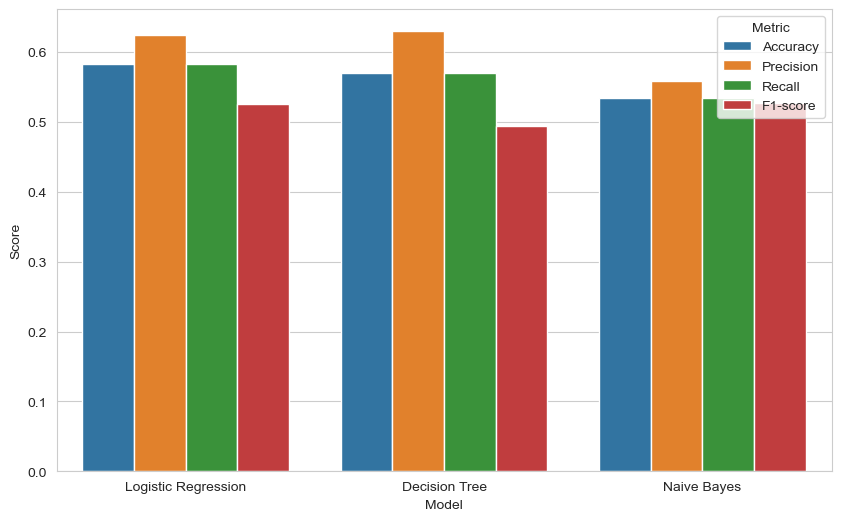

In [211]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metric_df)
plt.legend(title='Metric')
plt.show()

In [212]:
lr_conf_matrix = confusion_matrix(lr_cv_results['True Labels'], lr_cv_results['Predictions'])
dt_conf_matrix = confusion_matrix(dt_cv_results['True Labels'], dt_cv_results['Predictions'])
nb_conf_matrix = confusion_matrix(nb_cv_results['True Labels'], nb_cv_results['Predictions'])

#для наглядности перейдем от абсолютных значений к процентным
lr_conf_matrix = lr_conf_matrix.astype('float') / lr_conf_matrix.sum(axis=1)[:, np.newaxis] * 100
dt_conf_matrix = dt_conf_matrix.astype('float') / dt_conf_matrix.sum(axis=1)[:, np.newaxis] * 100
nb_conf_matrix = nb_conf_matrix.astype('float') / nb_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

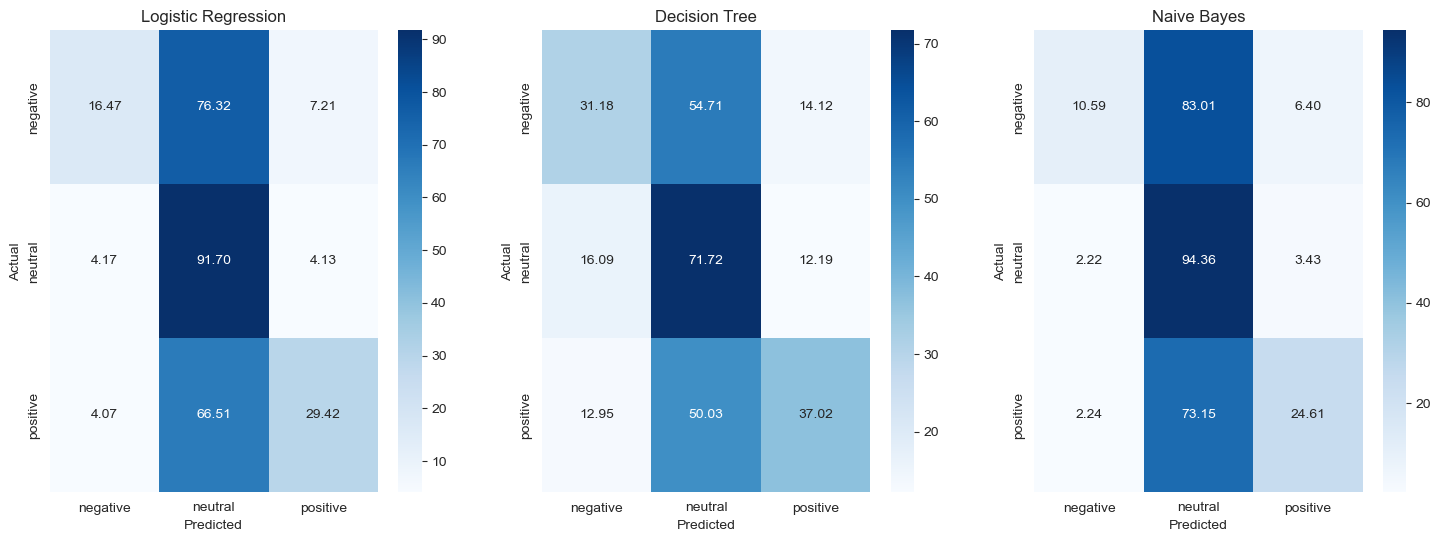

In [213]:
# Создаем subplots для отображения матриц ошибок
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, model in enumerate(zip(model_names, [lr_conf_matrix, dt_conf_matrix, nb_conf_matrix])):
    sns.heatmap(model[1], annot=True, fmt='0.2f', cmap='Blues', ax=axes[i], 
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
    axes[i].set_title(model[0])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.show()

Получили примерно тот же результат, но уже более устойчивый и надежный для дальнейшей интерпретации

В такой ситуации, хочется посмотреть на весовое распределение признаков для каждого класса, чтобы, во-первых, лучше понимать какие слова к примеру сильнее влияют на отнесение текста к тому или иному классу, а также увидеть

Попробуем посмотреть на распределение оценок по классам модели линейной регрессии, так как она достаточно хорошо интерпретируема

In [214]:
len(tfidf.get_feature_names_out()), len(lr_model.coef_.flatten())

(5000, 15000)

In [215]:
feature_names = tfidf.get_feature_names_out()
lr_coef = lr_model.coef_

lr_feature_df = pd.DataFrame({
    'Признак': feature_names,
    'negative': lr_coef[0],
    'neutral': lr_coef[1],
    'positive': lr_coef[2]})

lr_feature_df

,Признак,negative,neutral,positive
0,bmw,-0.043276,-0.036701,0.079977
1,coming,-0.082961,0.160468,-0.077508
2,day,0.000000,0.000000,0.000000
3,dd,-0.069220,0.120859,-0.051640
4,fuck,0.135650,-0.385401,0.249751
...,...,...,...,...
4995,января,0.229534,-0.005988,-0.223545
4996,яндексе,-0.009267,0.159807,-0.150540
4997,японии,-0.089920,0.155352,-0.065432
4998,ясен,0.142689,-0.079462,-0.063227


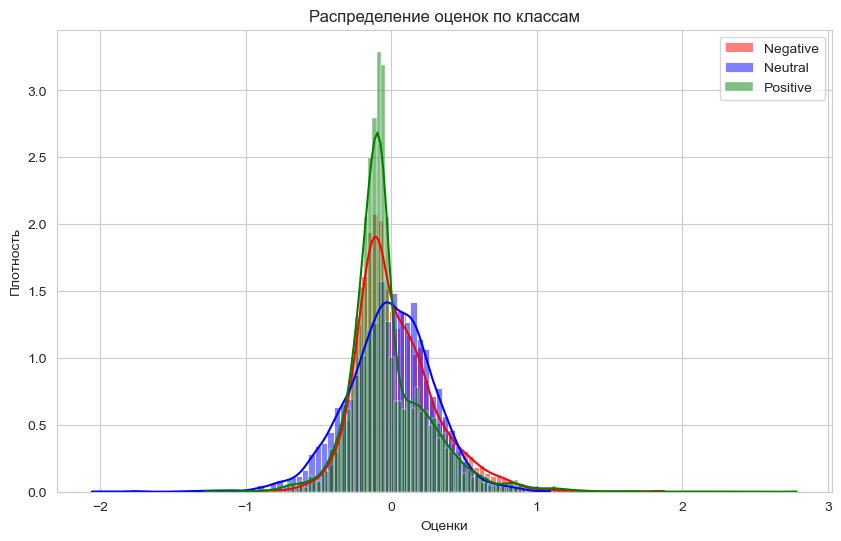

In [216]:
plt.figure(figsize=(10, 6))

# Используем Seaborn для построения гистограмм
sns.histplot(lr_feature_df['negative'], color='red', label='Negative', kde=True, stat="density")
sns.histplot(lr_feature_df['neutral'], color='blue', label='Neutral', kde=True, stat="density")
sns.histplot(lr_feature_df['positive'], color='green', label='Positive', kde=True, stat="density")

# Настраиваем отображение
plt.title('Распределение оценок по классам')
plt.xlabel('Оценки')
plt.ylabel('Плотность')
plt.legend()

# Шаг 2: Отобразить график
plt.show()

На гистограмме распределения оценок видно, что большинство значений (всех трех классов) сосредоточены в районе нуля. Графики плотности указывают на то, что оценки negative, neutral и positive перекрываются, что может приводить к сложности в их четком разделении.

Для большей наглядности для каждого признака посчитаем стандартное отклонение по оценкам всех классов.

Эта характеристика напрямую покажет, насколько хорошо признак репрезентует какой-либо класс (при малом отклонении можно считать, что признак малоинформативен для модели, т.к. имеет близкие оценки среди классов). 

In [217]:
lr_feature_df['std'] = lr_feature_df[['negative', 'neutral', 'positive']].std(axis=1)

# Шаг 2: Сортируем DataFrame по этой разнице
lr_feature_df = lr_feature_df.sort_values(by='std', ascending=False)
lr_feature_df

,Признак,negative,neutral,positive,std
1781,люблю,-1.016225,-1.767170,2.783396,2.439559
4785,хочу,0.018475,-2.055164,2.036689,2.045989
3821,скучаю,-0.369466,-1.789668,2.159133,2.000159
2703,пиздец,1.874022,-1.724301,-0.149721,1.803828
4004,соскучилась,-0.582261,-1.271487,1.853748,1.641964
...,...,...,...,...,...
3990,солнышка,0.000000,0.000000,0.000000,0.000000
3322,простенький,0.000000,0.000000,0.000000,0.000000
3341,прочие,0.000000,0.000000,0.000000,0.000000
671,годик,0.000000,0.000000,0.000000,0.000000


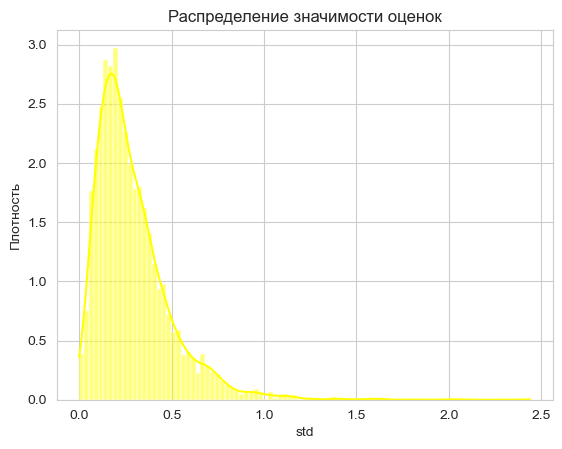

In [218]:
sns.histplot(lr_feature_df['std'], color='yellow', kde=True, stat="density")
plt.plot()
plt.title('Распределение значимости оценок')
plt.ylabel('Плотность')
plt.show()

На графике распределения значимости оценок по стандартному отклонению видно, что большая часть признаков имеют достаточно малое отклонение, т.е. плохо характеризуют класс с точки зрения модели.

Таким образом, можно обобщить, что на конечный результат обучения моделей повлияло сложное и неявное распределение исходных данных. На примере Logistic Regression, видно, что большую часть признаков модель "не различает". Улучшить результат, оставляя ту же модель, вероятно можно, используя более простой набор данных с точки зрения линейной разделимости (где признаки, характеризующие класс, встречаются гораздо чаще в экземплярах данного класса), однако стоит учитывать, что обобщаемость модели при этом явно не повысится, поскольку модель все равно не сможет оценивать контекст, а как следствие, и семантику того или иного слова (т.е. не сможет извлекать более сложные признаки).

Для улучшения результата уже меняя модель или предобработку текста, можно применить методы глубокого обучения, т.е. использовать более сложные методы векторизации текста. Либо использовать модели глубокого обучения, например нейронные сети на основе трансформеров, для продвинутого извлечения признаков.